# Diabetes Model Performance Analysis
This notebook evaluates the performance of the trained models on the test set.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import sys
import os

# Add src to path to import modules if needed
sys.path.append('..')
# Try importing from src, assuming notebook is in 'notebooks' or 'notebook' dir
try:
    from src.preprocessing import load_data, clean_data, feature_engineering, split_data, preprocess_features
except ImportError:
    print("Warning: src modules not found. Ensure project structure is correct.")

# If using hierarchical, we need its class definition
try:
    from src.train_hierarchical import HierarchicalClassifier
except ImportError:
    pass

# Configure plots
plt.style.use('ggplot')
%matplotlib inline

In [3]:
# 1. Load Data & Prepare Test Set
data_path = '../data/diabetes_012_health_indicators_BRFSS2015.csv'
if not os.path.exists(data_path):
    print(f"Data not found at {data_path}. Please running src/extract_data.py")
else:
    df = pd.read_csv(data_path)
    df = clean_data(df)
    df = feature_engineering(df)

    # Split
    X_train, X_test, y_train, y_test = split_data(df)
    print(f"Test Set Shape: {X_test.shape}")

Data cleaning complete. Removed 23899 rows (duplicates/missing). Final shape: (229781, 22)
Data split into Train ((183824, 21)) and Test ((45957, 21)) sets.
Test Set Shape: (45957, 21)


In [4]:
# 2. Load Models
models_dir = '../models'
models_to_eval = {}

if not os.path.exists(models_dir):
     print(f"Models directory not found at {models_dir}. Please run main.py to train models.")
else:
    # Check for Single Stage Model
    p1 = os.path.join(models_dir, 'diabetes_model.pkl')
    if os.path.exists(p1):
        print(f"Found Single-Stage Model: {p1}")
        data = joblib.load(p1)
        models_to_eval['Single-Stage (BRF)'] = {'model': data['model'], 'scaler': data['scaler']}

    # Check for Hierarchical Model
    p2 = os.path.join(models_dir, 'diabetes_hierarchical_model.pkl')
    if os.path.exists(p2):
        print(f"Found Hierarchical Model: {p2}")
        data = joblib.load(p2)
        try:
            hc = HierarchicalClassifier(data['stage1'], data['stage2'])
            models_to_eval['Hierarchical'] = {'model': hc, 'scaler': data['scaler']}
        except NameError:
            print("HierarchicalClassifier class not found in namespace.")
        except Exception as e:
            print(f"Error loading Hierarchical model: {e}")

    if not models_to_eval:
        print("No models found in models directory!")

Found Hierarchical Model: ../models\diabetes_hierarchical_model.pkl



Evaluating: Hierarchical
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84     38012
           1       0.04      0.06      0.05       926
           2       0.36      0.62      0.45      7019

    accuracy                           0.74     45957
   macro avg       0.44      0.49      0.45     45957
weighted avg       0.81      0.74      0.76     45957



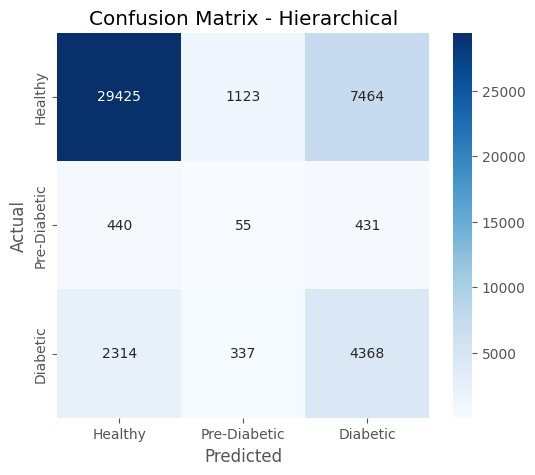

In [5]:
def evaluate(name, artifacts, X_test, y_test):
    print(f"\n{'='*20}\nEvaluating: {name}\n{'='*20}")
    model = artifacts['model']
    scaler = artifacts['scaler']
    
    # Preprocess Test Data (Scale)
    X_scaled = scaler.transform(X_test)
    
    # Predict
    y_pred = model.predict(X_scaled)
    
    # Metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Healthy', 'Pre-Diabetic', 'Diabetic'],
                yticklabels=['Healthy', 'Pre-Diabetic', 'Diabetic'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
for name, artifacts in models_to_eval.items():
    evaluate(name, artifacts, X_test, y_test)